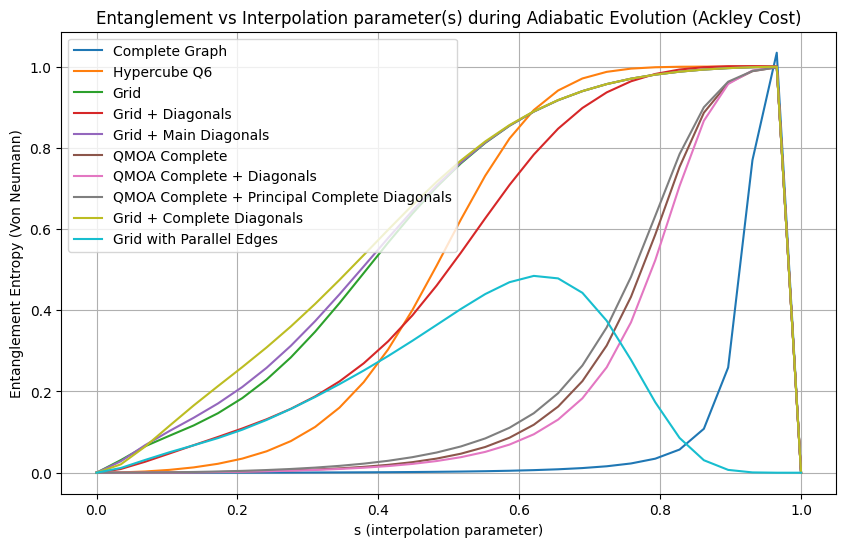

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.stats import entropy
rows, cols = 8, 8
n = rows * cols
# cost Hamiltonian (Ackley)
def ackley_cost(num_states):
    """Ackley cost for a 1D array of `num_states` points."""
    x = np.linspace(-5, 5, num_states)
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2)))
    term2 = -np.exp(0.5 * np.cos(2*np.pi*x))
    return term1 + term2 + 20 + np.e

# Reduced density matrix and entanglement entropy
def entanglement_entropy(statevector, n_qubits):
    """Compute Von Neumann entropy of first half of qubits"""
    dim_A = 2 ** (n_qubits // 2)
    dim_B = 2 ** (n_qubits - n_qubits // 2)
    psi = statevector.reshape(dim_A, dim_B)
    rho_A = psi @ psi.conj().T
    eigvals = np.linalg.eigvalsh(rho_A)
    eigvals = eigvals[eigvals > 1e-12]
    return -np.sum(eigvals * np.log2(eigvals))

    
    # ... compute entanglement ...

# Function: compute entanglement vs s
def compute_entanglement_vs_s(G, num_points=200):
    N = G.number_of_nodes()
    n_qubits = int(np.log2(N))  # log2(N_nodes)

    # Mixing Hamiltonian (Laplacian)
    H_M = nx.laplacian_matrix(G).todense().astype(float)

    # Cost Hamiltonian (Ackley)
    diag_cost = ackley_cost(N)
    H_C = np.diag(diag_cost)

    s_vals = np.linspace(0, 1, num_points)
    ent_vals = []
    prev_vec = None

    for s in s_vals:
        H_s = (1-s)*H_M + s*H_C
        eigvals, eigvecs = eigh(H_s)
        gs = eigvecs[:, 0]

        # Align ground state phase
        if prev_vec is not None and np.dot(prev_vec.conj(), gs) < 0:
            gs = -gs
        prev_vec = gs

        ent = entanglement_entropy(gs, n_qubits)
        ent_vals.append(ent)

    return s_vals, ent_vals
# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)
def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)
def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# Example: Add graphs (replace these with your existing graphs dict)
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q6": nx.convert_node_labels_to_integers(nx.hypercube_graph(6)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

plt.figure(figsize=(10,6))
for name, G in graphs.items():
    G = nx.convert_node_labels_to_integers(G)
    s_vals, ent_vals = compute_entanglement_vs_s(G, num_points=30)
    plt.plot(s_vals, ent_vals, label=name)

plt.xlabel("s (interpolation parameter)")
plt.ylabel("Entanglement Entropy (Von Neumann)")
plt.title("Entanglement vs Interpolation parameter(s) during Adiabatic Evolution (Ackley Cost)")
plt.legend()
plt.grid(True)
plt.show()

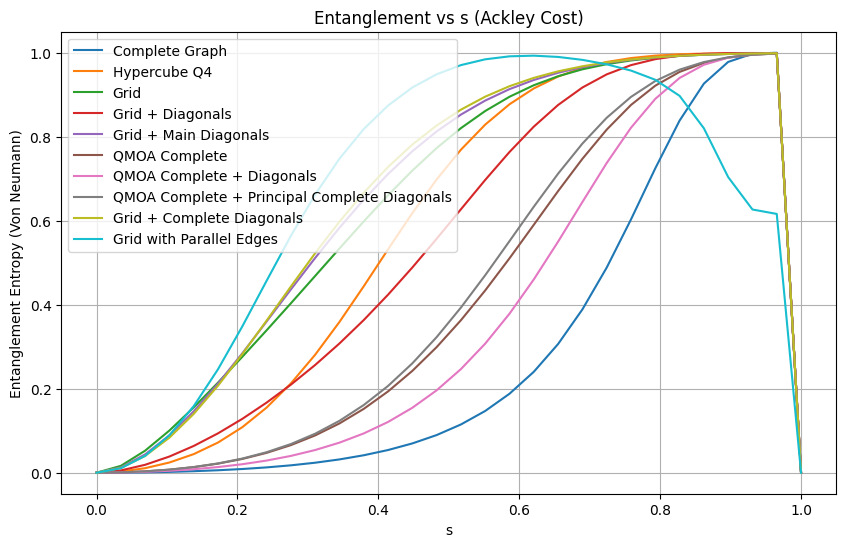

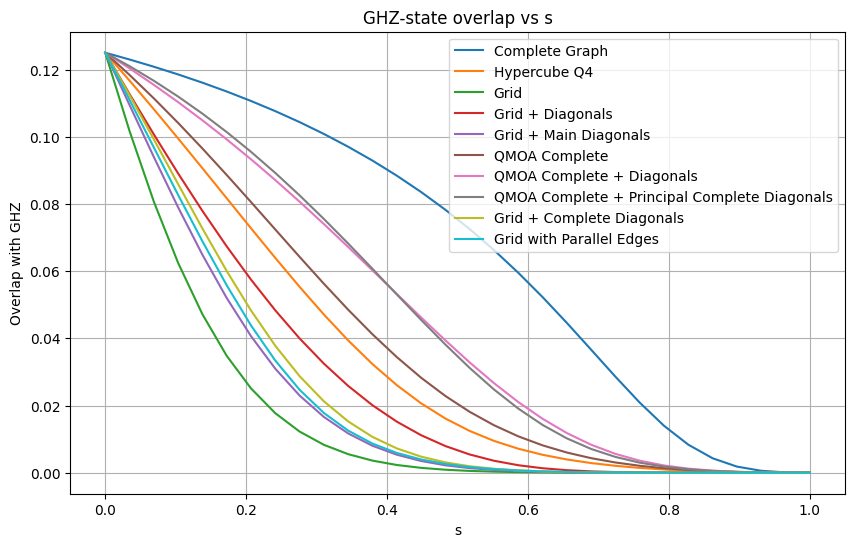

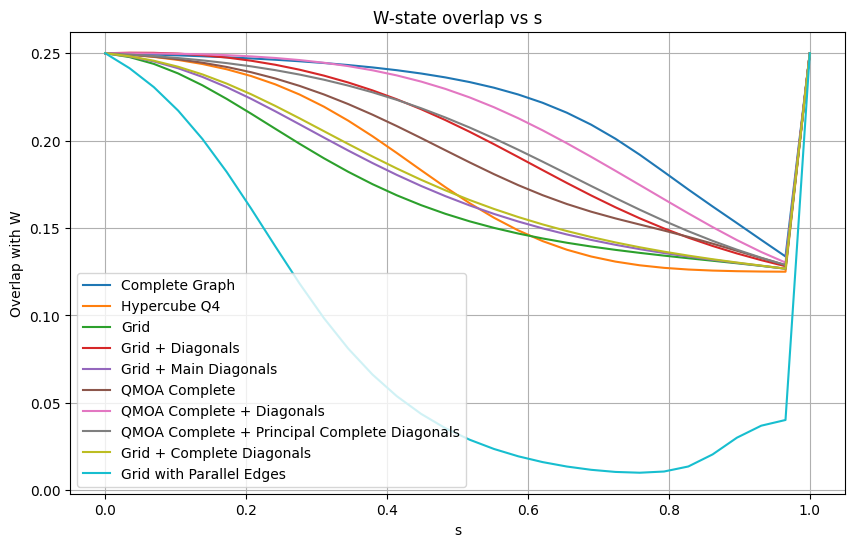

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# ===================== COST FUNCTION (Ackley) =====================
def ackley_cost(n):
    x = np.linspace(-5, 5, 2**n)
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2)))
    term2 = -np.exp(0.5 * (np.cos(2*np.pi*x)))
    return term1 + term2 + 20 + np.e

# ===================== ENTANGLEMENT ENTROPY =====================
def entanglement_entropy(statevector, n_qubits):
    dim_A = 2 ** (n_qubits // 2)
    dim_B = 2 ** (n_qubits - n_qubits // 2)
    psi = statevector.reshape(dim_A, dim_B)
    rho_A = psi @ psi.conj().T
    eigvals = np.linalg.eigvalsh(rho_A)
    eigvals = eigvals[eigvals > 1e-12]
    return -np.sum(eigvals * np.log2(eigvals))

# ===================== GHZ and W states =====================
def ghz_state(n):
    v = np.zeros(2**n)
    v[0] = 1/np.sqrt(2)
    v[-1] = 1/np.sqrt(2)
    return v

def w_state(n):
    v = np.zeros(2**n)
    for i in range(n):
        v[1<<i] = 1/np.sqrt(n)
    return v

def state_overlap(psi, target):
    return np.abs(np.dot(np.conj(target), psi))**2

# ===================== COMPUTATION FUNCTION =====================
def compute_entanglement_and_overlaps_vs_s(G, num_points=30):
    n = int(np.log2(G.number_of_nodes()))
    # Hamiltonians
    H_M = nx.laplacian_matrix(G).todense().astype(float)
    diag_cost = ackley_cost(n)
    H_C = np.diag(diag_cost[:2**n]) 

    s_vals = np.linspace(0, 1, num_points)
    ent_vals = []
    ghz_vals = []
    w_vals = []

    ghz = ghz_state(n)
    w = w_state(n)

    prev_vec = None
    for s in s_vals:
        H_s = (1-s)*H_M + s*H_C
        eigvals, eigvecs = eigh(H_s)
        gs = eigvecs[:, 0]

        # Phase alignment for smooth overlaps
        if prev_vec is not None and np.dot(prev_vec.conj(), gs) < 0:
            gs = -gs
        prev_vec = gs

        ent = entanglement_entropy(gs, n)
        ov_ghz = state_overlap(gs, ghz)
        ov_w   = state_overlap(gs, w)

        ent_vals.append(ent)
        ghz_vals.append(ov_ghz)
        w_vals.append(ov_w)

    return s_vals, ent_vals, ghz_vals, w_vals

# ===================== GRAPH BUILDERS =====================
def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)
def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")

def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)
def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G
def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)


# ===================== MAIN EXECUTION =====================
rows, cols = 4, 4  # smaller size to make 16 nodes = 4 qubits
n = rows * cols

graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q4": nx.convert_node_labels_to_integers(nx.hypercube_graph(4)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols),

}
# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# Plot 1: Entanglement entropy
plt.figure(figsize=(10, 6))
for name, G in graphs.items():
    s_vals, ent_vals, ghz_vals, w_vals = compute_entanglement_and_overlaps_vs_s(G, num_points=30)
    plt.plot(s_vals, ent_vals, label=name)
plt.xlabel("s")
plt.ylabel("Entanglement Entropy (Von Neumann)")
plt.title("Entanglement vs s (Ackley Cost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: GHZ overlap
plt.figure(figsize=(10, 6))
for name, G in graphs.items():
    s_vals, ent_vals, ghz_vals, w_vals = compute_entanglement_and_overlaps_vs_s(G, num_points=30)
    plt.plot(s_vals, ghz_vals, label=name)
plt.xlabel("s")
plt.ylabel("Overlap with GHZ")
plt.title("GHZ-state overlap vs s")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: W overlap
plt.figure(figsize=(10, 6))
for name, G in graphs.items():
    s_vals, ent_vals, ghz_vals, w_vals = compute_entanglement_and_overlaps_vs_s(G, num_points=30)
    plt.plot(s_vals, w_vals, label=name)
plt.xlabel("s")
plt.ylabel("Overlap with W")
plt.title("W-state overlap vs s")
plt.legend()
plt.grid(True)
plt.show()

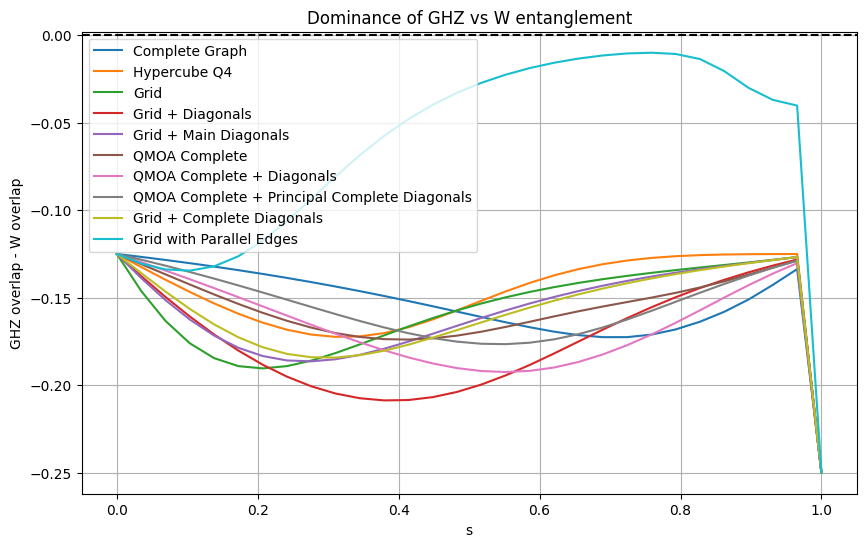

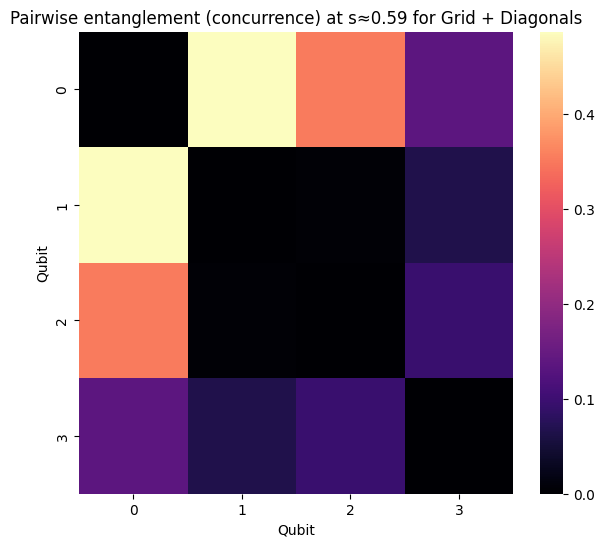

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from itertools import combinations

# --- Function to compute concurrence for a 2-qubit reduced density matrix ---
def concurrence(rho):
    # Wootters concurrence for 2-qubit state
    Y = np.array([[0,-1],[1,0]])
    R = rho @ np.kron(Y,Y) @ rho.conj() @ np.kron(Y,Y)
    eigvals = np.sqrt(np.sort(np.real(np.linalg.eigvals(R)))[::-1])
    return max(0, eigvals[0] - eigvals[1] - eigvals[2] - eigvals[3])

def reduced_density_matrix(statevector, qubit_indices, n_qubits):
    """
    Compute reduced density matrix by tracing out all qubits except `qubit_indices`.
    Uses explicit reshaping and np.tensordot to avoid axis misalignment.
    """
    dim = 2 ** n_qubits
    assert len(statevector) == dim, f"Expected statevector of length 2^{n_qubits}, got {len(statevector)}"

    # Full density matrix
    rho = np.outer(statevector, statevector.conj())
    rho = rho.reshape([2] * (2 * n_qubits))

    keep = list(qubit_indices)
    traced_out = [i for i in range(n_qubits) if i not in keep]

    # Perform partial trace
    for count, q in enumerate(sorted(traced_out, reverse=True)):
        # After each trace, the number of axes decreases by 2
        axis1 = q
        axis2 = q + (rho.ndim // 2)
        rho = np.trace(rho, axis1=axis1, axis2=axis2)

    final_dim = 2 ** len(keep)
    return rho.reshape((final_dim, final_dim))

def compute_pairwise_concurrences(gs, n_qubits):
    conc = np.zeros((n_qubits, n_qubits))
    for i,j in combinations(range(n_qubits), 2):
        rho_ij = reduced_density_matrix(gs, (i,j), n_qubits)
        conc[i,j] = conc[j,i] = concurrence(rho_ij)
    return conc

# --- Extend your existing compute_entanglement_vs_s function ---
def compute_entanglement_and_overlaps(G, num_points=30):
    n = int(np.log2(G.number_of_nodes()))
    H_M = nx.laplacian_matrix(G).todense().astype(float)

    # Ackley cost diagonal (reuse your ackley_cost)
    diag_cost = ackley_cost(n)
    H_C = np.diag(diag_cost[:2**n])

    # Prepare GHZ and W states
    ghz = (np.zeros(2**n)); ghz[0] = 1; ghz[-1] = 1
    ghz = ghz / np.linalg.norm(ghz)
    w_state = np.zeros(2**n)
    for i in range(n):
        w_state[1 << i] = 1
    w_state /= np.sqrt(n)

    s_vals = np.linspace(0, 1, num_points)
    ent_vals, ghz_ov, w_ov = [], [], []

    pairwise_data = {}  # store concurrence matrices at mid s

    for s in s_vals:
        H_s = (1-s)*H_M + s*H_C
        eigvals, eigvecs = eigh(H_s)
        gs = eigvecs[:, 0]

        # Entropy
        ent = entanglement_entropy(gs, n)
        ent_vals.append(ent)

        # Overlaps
        ghz_ov.append(abs(np.vdot(ghz, gs))**2)
        w_ov.append(abs(np.vdot(w_state, gs))**2)

        # Capture pairwise entanglement at s ≈ 0.6
        if abs(s-0.6)<0.02:
            pairwise_data[s] = compute_pairwise_concurrences(gs, n)

    return s_vals, np.array(ent_vals), np.array(ghz_ov), np.array(w_ov), pairwise_data


# === MAIN: Dominance plot ===
plt.figure(figsize=(10,6))
dominance_data = {}
pairwise_heatmaps = {}
for name, G in graphs.items():
    s_vals, ent_vals, ghz_ov, w_ov, pairwise_data = compute_entanglement_and_overlaps(G)
    dominance = ghz_ov - w_ov
    plt.plot(s_vals, dominance, label=name)
    dominance_data[name] = dominance
    pairwise_heatmaps[name] = pairwise_data

plt.axhline(0, color='black', linestyle='--')
plt.xlabel("s")
plt.ylabel("GHZ overlap - W overlap")
plt.title("Dominance of GHZ vs W entanglement")
plt.legend()
plt.grid(True)
plt.show()

# === Plot a pairwise heatmap for one graph at s ≈ 0.6 ===
import seaborn as sns
graph_to_plot = "Grid + Diagonals"  # change as needed
chosen_s = list(pairwise_heatmaps[graph_to_plot].keys())[0]
plt.figure(figsize=(7,6))
sns.heatmap(pairwise_heatmaps[graph_to_plot][chosen_s], cmap='magma', annot=False)
plt.title(f"Pairwise entanglement (concurrence) at s≈{chosen_s:.2f} for {graph_to_plot}")
plt.xlabel("Qubit")
plt.ylabel("Qubit")
plt.show()

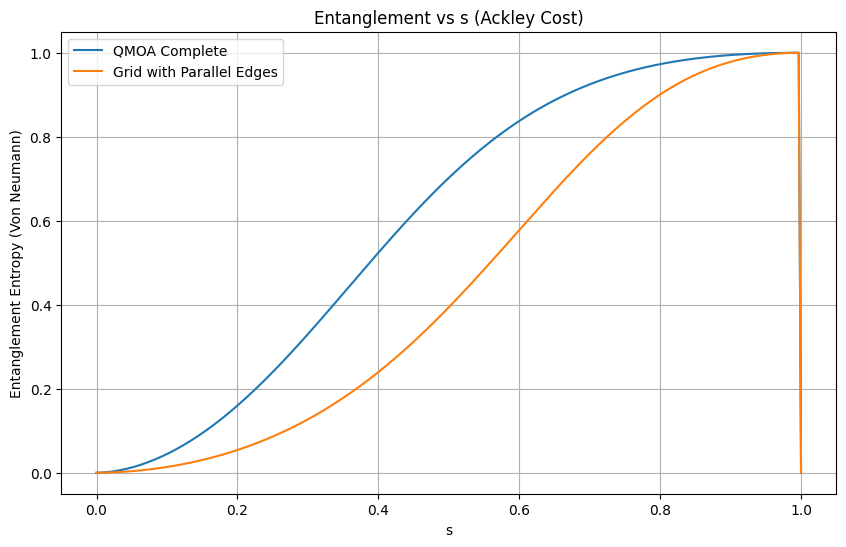

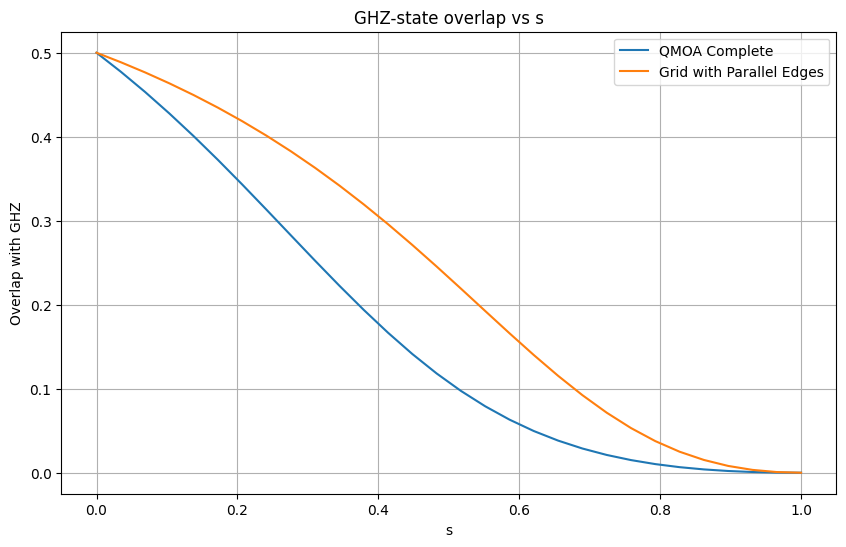

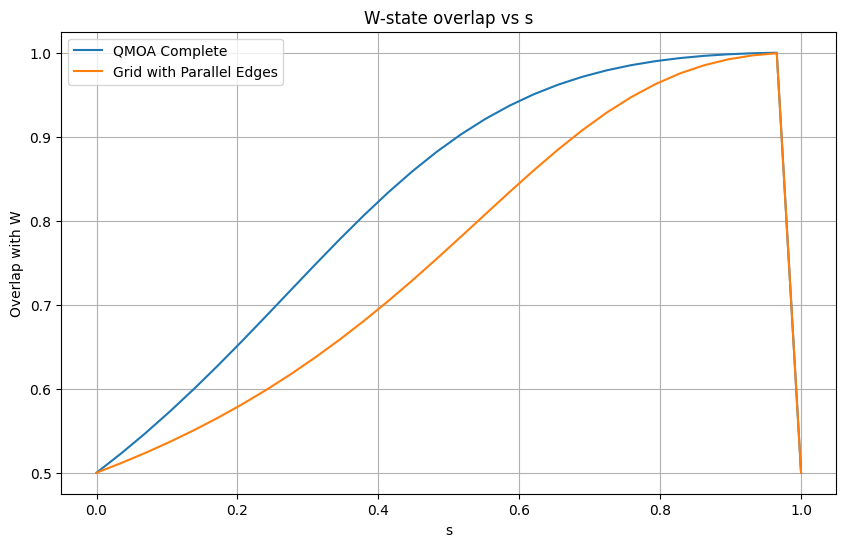

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# ===================== COST FUNCTION (Ackley) =====================
def ackley_cost(n):
    x = np.linspace(-5, 5, 2**n)
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2)))
    term2 = -np.exp(0.5 * (np.cos(2*np.pi*x)))
    return term1 + term2 + 20 + np.e

# ===================== ENTANGLEMENT ENTROPY =====================
def entanglement_entropy(statevector, n_qubits):
    dim_A = 2 ** (n_qubits // 2)
    dim_B = 2 ** (n_qubits - n_qubits // 2)
    psi = statevector.reshape(dim_A, dim_B)
    rho_A = psi @ psi.conj().T
    eigvals = np.linalg.eigvalsh(rho_A)
    eigvals = eigvals[eigvals > 1e-12]
    return -np.sum(eigvals * np.log2(eigvals))

# ===================== GHZ and W states =====================
def ghz_state(n):
    v = np.zeros(2**n)
    v[0] = 1/np.sqrt(2)
    v[-1] = 1/np.sqrt(2)
    return v

def w_state(n):
    v = np.zeros(2**n)
    for i in range(n):
        v[1<<i] = 1/np.sqrt(n)
    return v

def state_overlap(psi, target):
    return np.abs(np.dot(np.conj(target), psi))**2

# ===================== COMPUTATION FUNCTION =====================
def compute_entanglement_and_overlaps_vs_s(G, num_points=300):
    n = int(np.log2(G.number_of_nodes()))
    # Hamiltonians
    H_M = nx.laplacian_matrix(G).todense().astype(float)
    diag_cost = ackley_cost(n)
    H_C = np.diag(diag_cost[:2**n]) 

    s_vals = np.linspace(0, 1, num_points)
    ent_vals = []
    ghz_vals = []
    w_vals = []

    ghz = ghz_state(n)
    w = w_state(n)

    prev_vec = None
    for s in s_vals:
        H_s = (1-s)*H_M + s*H_C
        eigvals, eigvecs = eigh(H_s)
        gs = eigvecs[:, 0]

        # Phase alignment for smooth overlaps
        if prev_vec is not None and np.dot(prev_vec.conj(), gs) < 0:
            gs = -gs
        prev_vec = gs

        ent = entanglement_entropy(gs, n)
        ov_ghz = state_overlap(gs, ghz)
        ov_w   = state_overlap(gs, w)

        ent_vals.append(ent)
        ghz_vals.append(ov_ghz)
        w_vals.append(ov_w)

    return s_vals, ent_vals, ghz_vals, w_vals

# ===================== GRAPH BUILDERS =====================
def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)
def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")

def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)
def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G
def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)


# ===================== MAIN EXECUTION =====================
rows, cols = 2, 2  # smaller size to make 16 nodes = 4 qubits
n = rows * cols

graphs = {
    #"Complete Graph": nx.complete_graph(n),
    #"Hypercube Q4": nx.convert_node_labels_to_integers(nx.hypercube_graph(4)),
    #"Grid": build_grid(rows, cols),
    #"Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    #"Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    #"QMOA Complete + Diagonals": build_qmoa_with_diagonals(rows, cols),
    #"QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    #"Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols),

}
# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# Plot 1: Entanglement entropy
plt.figure(figsize=(10, 6))
for name, G in graphs.items():
    s_vals, ent_vals, ghz_vals, w_vals = compute_entanglement_and_overlaps_vs_s(G, num_points=300)
    plt.plot(s_vals, ent_vals, label=name)
plt.xlabel("s")
plt.ylabel("Entanglement Entropy (Von Neumann)")
plt.title("Entanglement vs s (Ackley Cost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: GHZ overlap
plt.figure(figsize=(10, 6))
for name, G in graphs.items():
    s_vals, ent_vals, ghz_vals, w_vals = compute_entanglement_and_overlaps_vs_s(G, num_points=30)
    plt.plot(s_vals, ghz_vals, label=name)
plt.xlabel("s")
plt.ylabel("Overlap with GHZ")
plt.title("GHZ-state overlap vs s")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: W overlap
plt.figure(figsize=(10, 6))
for name, G in graphs.items():
    s_vals, ent_vals, ghz_vals, w_vals = compute_entanglement_and_overlaps_vs_s(G, num_points=30)
    plt.plot(s_vals, w_vals, label=name)
plt.xlabel("s")
plt.ylabel("Overlap with W")
plt.title("W-state overlap vs s")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def entanglement_entropy(statevector, n_qubits):
    dim_A = 2 ** (n_qubits // 2)
    dim_B = 2 ** (n_qubits - n_qubits // 2)
    psi = statevector.reshape(dim_A, dim_B)
    rho_A = psi @ psi.conj().T
    eigvals = np.linalg.eigvalsh(rho_A)
    eigvals = eigvals[eigvals > 1e-12]
    return -np.sum(eigvals * np.log2(eigvals))
bell = np.array([0,1/np.sqrt(3),1/np.sqrt(3),0,1/np.sqrt(3),0,0,0], dtype = complex)
S = entanglement_entropy(bell, n_qubits=3)
print(S)

0.9182958340544893
